# **Import packages**

In [0]:
import pandas
from keras.models import Sequential, Model
from keras.layers import Input,Conv2D,MaxPooling2D,Dense,UpSampling2D, Activation, Flatten,BatchNormalization,Dropout, Cropping2D, concatenate, ZeroPadding2D
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from keras.optimizers import SGD, adam, RMSprop
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# **Simple Classification**

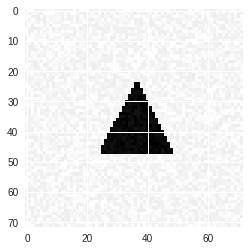

In [71]:
# On some implementations of matplotlib, you may need to change this value

def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)


def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]


im = generate_a_rectangle(10, True)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

im = generate_a_disk(10)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

[im, v] = generate_a_triangle(20, False)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')


def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    print('Creating data:')
    for i in range(nb_samples):
        #if i % 10 == 0:
        #    print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    print('Created ' + str(nb_samples) + ' samples')
    return [X, Y]

def generate_test_set_classification(nb_samples, noise=0.0):
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(nb_samples, noise, True)
    Y_test = np_utils.to_categorical(Y_test, 3) 
    return [X_test, Y_test]

def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    print('Creating data:')
    for i in range(nb_samples):
        #if i % 10 == 0:
        #    print(i)
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    print('Created ' + str(nb_samples) + ' samples')
    return [X, Y]

import matplotlib.patches as patches

def visualize_prediction(x, y):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

    plt.show()

def generate_test_set_regression(nb_samples, noise = 0.0):
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(nb_samples, noise)
    return [X_test, Y_test]


## **Create Train and Test sets**




In [0]:
[X_train_class, Y_train_class] = generate_dataset_classification(300, 20)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


## **Create dummies**

In [0]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

Firstly, we should transform our output to dummy variables. Indeed, most of artichetctures accept only the 1, 0 values as output.

In [0]:
encoder = LabelEncoder()
encoder.fit(Y_train_class)
encoded_Y = encoder.transform(Y_train_class)
# convert integers to dummy variables (i.e. one hot encoded)
Y_train_class_dummy = np_utils.to_categorical(encoded_Y)

In [0]:
categories = {0: "rectangle", 1: "disk", 2: "triangle"}

## **Create Model**

We start by a simple model that contains only a layer of three neurons . We use softmax as an activation function because we have a multiclass classification problem. 

In [0]:
nb_classes = 3

#Initialise a model
model =Sequential()
# Add output layer
model.add(Dense(nb_classes,input_shape=(X_train_class.shape[1],),activation = 'softmax'))

#Compile the model 
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam',metrics=['acc']) 

#Fit the model
results= model.fit(X_train_class,Y_train_class_dummy,validation_split=0.3,epochs=100,batch_size=5)

Train on 210 samples, validate on 90 samples
Epoch 1/100
210/210 [==============================] - 1s 6ms/step - loss: 1.3226 - acc: 0.4857 - val_loss: 0.6606 - val_acc: 0.6222
Epoch 2/100
210/210 [==============================] - 0s 467us/step - loss: 0.5110 - acc: 0.7381 - val_loss: 0.7541 - val_acc: 0.6556
Epoch 3/100
210/210 [==============================] - 0s 432us/step - loss: 0.3714 - acc: 0.8333 - val_loss: 0.3082 - val_acc: 0.8444
Epoch 4/100
210/210 [==============================] - 0s 449us/step - loss: 0.2620 - acc: 0.9000 - val_loss: 0.1489 - val_acc: 0.9889
Epoch 5/100
210/210 [==============================] - 0s 474us/step - loss: 0.2150 - acc: 0.9095 - val_loss: 0.1224 - val_acc: 0.9889
Epoch 6/100
210/210 [==============================] - 0s 489us/step - loss: 0.1280 - acc: 0.9619 - val_loss: 0.1149 - val_acc: 1.0000
Epoch 7/100
210/210 [==============================] - 0s 414us/step - loss: 0.0978 - acc: 0.9857 - val_loss: 0.1074 - val_acc: 1.0000
Epoch 8/100


## **Plot model accuracy**

We plot the accuracy as a function of number of epochs.

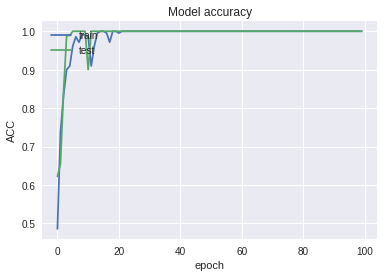

In [0]:
# history for MSE
plt.plot(results.history['acc'])
plt.plot(results.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('ACC')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## **Visualization**

We extracts the weight of the only layer that we have. Every column represents a class as you will see below.

In [0]:
weights = model.get_weights()[0]

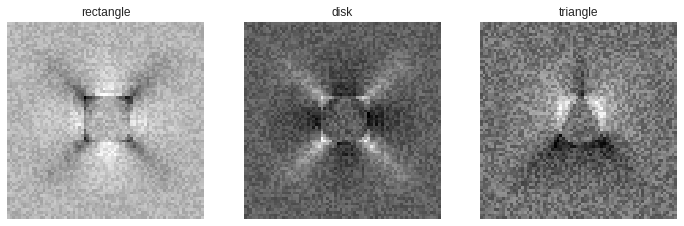

In [0]:
n = weights.shape[1]
plt.figure(figsize=(12, 13))
for i in range(1, n+1):

    # display original
    im = weights[:,i-1]
    ax = plt.subplot(2, n, i)
    plt.title(categories[i-1])
    plt.imshow(im.reshape(72, 72))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

# **A More Difficult Classification Problem**

In this part, the image changes its location. So a simple classifier is not sufficient to do a good classification. We need for that a model that captures the information from all the image and get some features using filters. These filters capture some patterns from the image whatever their locations and help to get strong results.

## **Data preprocessing**

In [0]:
[X_train_class2, Y_train_class2] = generate_dataset_classification(1000, 20, True)
[X_test_class2, Y_test_class2] = generate_test_set_classification(300, 20)

Creating data:
Created 1000 samples


In [0]:
X_train_class2_reshaped = X_train_class2.reshape(1000,72,72,1)
X_test_class2_reshaped  = X_test_class2.reshape(300,72,72,1)

Creating data:
Created 300 samples


In [0]:
encoder = LabelEncoder()
encoder.fit(Y_train_class2)
encoded_Y = encoder.transform(Y_train_class2)
# convert integers to dummy variables (i.e. one hot encoded)
Y_train_class2_dummy = np_utils.to_categorical(encoded_Y)

## **One-Layer Model**

We start by creating a model of one convolutional layer. we use maxpooling in order to downsample the image in the input. This process helps to get some good patterns and avoid overfitting.

### **Create model**

In [0]:
nb_of_classes = 3

cnn1 =Sequential()

cnn1.add(Conv2D(16,kernel_size=(5,5),input_shape=(72,72,1,)))
cnn1.add(MaxPooling2D(pool_size=(3,3)))
cnn1.add(Flatten())
cnn1.add(Dense(nb_of_classes,activation = 'softmax'))

###########Compile the model################### 
cnn1.compile(loss = 'categorical_crossentropy', optimizer = 'adam',metrics=['acc']) 

results_cnn1= cnn1.fit(X_train_class2_reshaped,Y_train_class2_dummy,validation_data=(X_test_class2_reshaped,Y_test_class2),epochs=10,batch_size=32)

Train on 1000 samples, validate on 300 samples
Epoch 1/10
1000/1000 [==============================] - 5s 5ms/step - loss: 0.5606 - acc: 0.7920 - val_loss: 0.6509 - val_acc: 0.7500
Epoch 2/10
1000/1000 [==============================] - 4s 4ms/step - loss: 0.5505 - acc: 0.7990 - val_loss: 0.6854 - val_acc: 0.6867
Epoch 3/10
1000/1000 [==============================] - 4s 4ms/step - loss: 0.5399 - acc: 0.7980 - val_loss: 0.5949 - val_acc: 0.7800
Epoch 4/10
1000/1000 [==============================] - 4s 4ms/step - loss: 0.4977 - acc: 0.8310 - val_loss: 0.6270 - val_acc: 0.7100
Epoch 5/10
1000/1000 [==============================] - 4s 4ms/step - loss: 0.5161 - acc: 0.8070 - val_loss: 0.6312 - val_acc: 0.7067
Epoch 6/10
1000/1000 [==============================] - 4s 4ms/step - loss: 0.5180 - acc: 0.8020 - val_loss: 0.5600 - val_acc: 0.7733
Epoch 7/10
1000/1000 [==============================] - 4s 4ms/step - loss: 0.4618 - acc: 0.8360 - val_loss: 0.5471 - val_acc: 0.7867
Epoch 8/10
1000

### **Evaluate model**

In [0]:
eval_cnn1 = cnn1.evaluate(X_test_class2_reshaped, Y_test_class2)
print("Loss: ", str(eval_cnn1[0]))
print("Accuracy: ", str(eval_cnn1[1]))

300/300 [==============================] - 1s 2ms/step
Loss:  1.1907444890340169
Accuracy:  0.34000000009934106


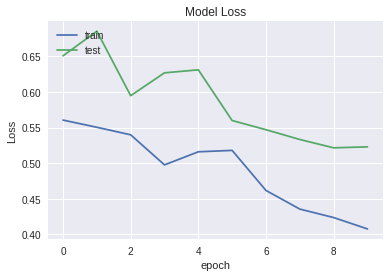

In [0]:
# history for Loss
plt.plot(results_cnn1.history['loss'])
plt.plot(results_cnn1.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

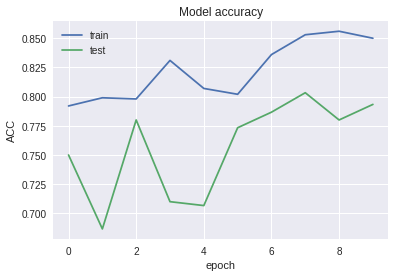

In [0]:
# history for MSE
plt.plot(results_cnn1.history['acc'])
plt.plot(results_cnn1.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('ACC')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### **Visualization**

In [0]:
preds_cnn1 = cnn1.predict(X_test_class2_reshaped)

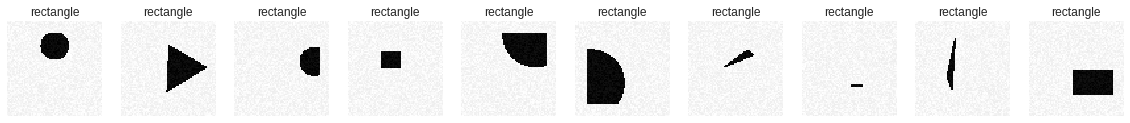

In [0]:
n = 10
plt.figure(figsize=(20, 20))
for i in range(1, n+1):

    # display test
    im = X_test_class2_reshaped[i-1,:,:,0]
    ax = plt.subplot(2, n, i)
    # write class prediction
    plt.title(categories[preds_cnn1[i-1].argmax()])
    plt.imshow(im)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

## **Three-Layer Model**

In this final model, we create a model of three concolutional layers. In addition to max pooling, we drop out some neurons in order to reduce the overfitting and increase the speed of convergence.

### **Create model**

In [0]:
cnn3 = Sequential()
cnn3.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(72,72,1,)))
cnn3.add(MaxPooling2D((2, 2)))
cnn3.add(Dropout(0.25))

cnn3.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
cnn3.add(MaxPooling2D(pool_size=(2, 2)))
cnn3.add(Dropout(0.25))

cnn3.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
cnn3.add(Dropout(0.4))

cnn3.add(Flatten())

cnn3.add(Dense(128, activation='relu'))
cnn3.add(Dropout(0.3))
cnn3.add(Dense(3, activation='softmax'))

cnn3.compile(loss = 'categorical_crossentropy', optimizer = 'adam',metrics=['acc'])

results_cnn3= cnn3.fit(X_train_class2_reshaped,Y_train_class2_dummy,validation_data=(X_test_class2_reshaped,Y_test_class2),epochs=50,batch_size=32)

Train on 1000 samples, validate on 300 samples
Epoch 1/50
1000/1000 [==============================] - 15s 15ms/step - loss: 1.0907 - acc: 0.4050 - val_loss: 0.8849 - val_acc: 0.5967
Epoch 2/50
1000/1000 [==============================] - 13s 13ms/step - loss: 0.7683 - acc: 0.6340 - val_loss: 0.7400 - val_acc: 0.6467
Epoch 3/50
1000/1000 [==============================] - 13s 13ms/step - loss: 0.6196 - acc: 0.7320 - val_loss: 0.5932 - val_acc: 0.7967
Epoch 4/50
1000/1000 [==============================] - 13s 13ms/step - loss: 0.4512 - acc: 0.8260 - val_loss: 0.3639 - val_acc: 0.8700
Epoch 5/50
1000/1000 [==============================] - 13s 13ms/step - loss: 0.2030 - acc: 0.9230 - val_loss: 0.1570 - val_acc: 0.9433
Epoch 6/50
1000/1000 [==============================] - 13s 13ms/step - loss: 0.1407 - acc: 0.9490 - val_loss: 0.1498 - val_acc: 0.9400
Epoch 7/50
1000/1000 [==============================] - 13s 13ms/step - loss: 0.0846 - acc: 0.9720 - val_loss: 0.1496 - val_acc: 0.9433
E

### **Evaluate model**

In [0]:
eval_cnn3 = cnn3.evaluate(X_test_class2_reshaped, Y_test_class2)
print("Loss: ", str(eval_cnn3[0]))
print("Accuracy: ", str(eval_cnn3[1]))

300/300 [==============================] - 1s 3ms/step
Loss:  0.061559564437096315
Accuracy:  0.98


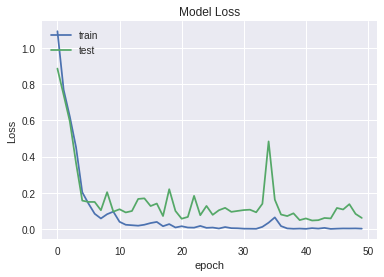

In [0]:
# history for Loss
plt.plot(results_cnn3.history['loss'])
plt.plot(results_cnn3.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

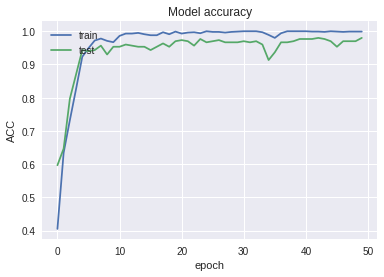

In [0]:
# history for accuracy
plt.plot(results_cnn3.history['acc'])
plt.plot(results_cnn3.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('ACC')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### **Visualization**

In [0]:
preds_cnn3 = cnn3.predict(X_test_class2_reshaped)

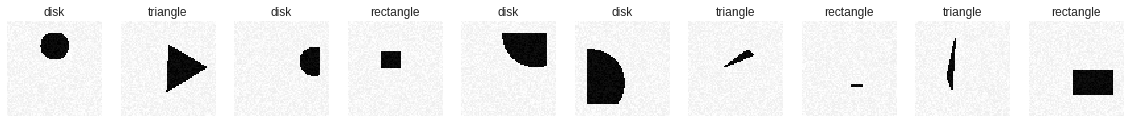

In [0]:
n = 10
plt.figure(figsize=(20, 20))
for i in range(1, n+1):

    # display test
    im = X_test_class2_reshaped[i-1,:,:,0]
    ax = plt.subplot(2, n, i)
    # write class prediction
    plt.title(categories[preds_cnn3[i-1].argmax()])
    plt.imshow(im)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

# **A Regression Problem**


## **Data preprocessing**

In [86]:
[X_train_reg, Y_train_reg] = generate_dataset_regression(1000, 20)
[X_test_reg, Y_test_reg]   = generate_test_set_regression(300, 20)

Creating data:
Created 1000 samples
Creating data:
Created 50 samples


### **Reshape**

In [0]:
X_train_reg_reshaped = X_train_reg.reshape(len(X_train_reg),72,72,1)
X_test_reg_reshaped  = X_test_reg.reshape(len(X_test_reg),72,72,1)

### **Normalising**

In [0]:
normalizer       = StandardScaler()
Y_train_reg_norm = normalizer.fit_transform(Y_train_reg)
Y_test_reg_norm  = normalizer.transform(Y_test_reg)

## **First model**

We start by creating a simple regressor that has only one output layer

### **Create model**

In [95]:
#A basic linear regressor model
reg_1   = Sequential()
reg_1.add(Dense(6,input_shape=(X_train_reg.shape[1],), activation='linear'))


#Compile the model 
reg_1.compile(loss='mean_squared_error',
              optimizer='adam')

results_reg_1 = reg_1.fit(X_train_reg,Y_train_reg_norm,epochs=50,batch_size=32, validation_data=(X_test_reg, Y_test_reg_norm))

Train on 1000 samples, validate on 300 samples
Epoch 1/50
1000/1000 [==============================] - 1s 715us/step - loss: 3.1126 - mean_squared_error: 3.1126 - val_loss: 1.4270 - val_mean_squared_error: 1.4270
Epoch 2/50
1000/1000 [==============================] - 0s 105us/step - loss: 0.9707 - mean_squared_error: 0.9707 - val_loss: 0.9227 - val_mean_squared_error: 0.9227
Epoch 3/50
1000/1000 [==============================] - 0s 104us/step - loss: 0.8153 - mean_squared_error: 0.8153 - val_loss: 0.7729 - val_mean_squared_error: 0.7729
Epoch 4/50
1000/1000 [==============================] - 0s 103us/step - loss: 0.7635 - mean_squared_error: 0.7635 - val_loss: 0.8059 - val_mean_squared_error: 0.8059
Epoch 5/50
1000/1000 [==============================] - 0s 110us/step - loss: 0.7403 - mean_squared_error: 0.7403 - val_loss: 0.8171 - val_mean_squared_error: 0.8171
Epoch 6/50
1000/1000 [==============================] - 0s 104us/step - loss: 0.7680 - mean_squared_error: 0.7680 - val_los

### **Evaluate model**

In [96]:
eval_reg1 = reg_1.evaluate(X_test_reg, Y_test_reg_norm)
print("Loss: ", str(eval_reg1[0]))
print("MSE: ", str(eval_reg1[1]))

300/300 [==============================] - 0s 68us/step
Loss:  0.8651136970520019
MSE:  0.8651136970520019


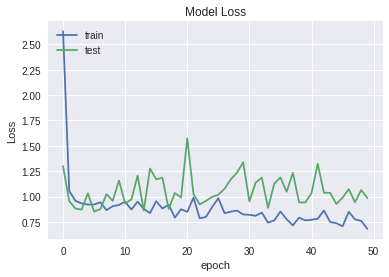

In [33]:
# history for Loss
plt.plot(results_reg_1.history['loss'])
plt.plot(results_reg_1.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### **Visualization**

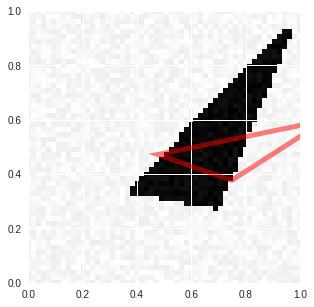

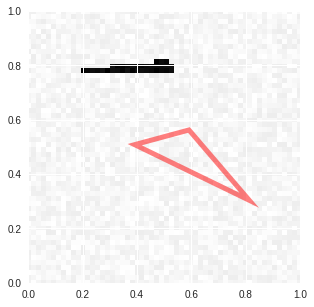

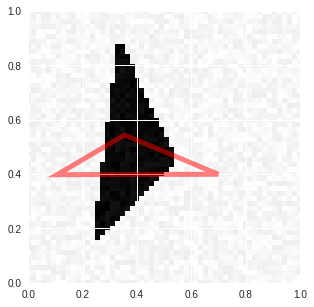

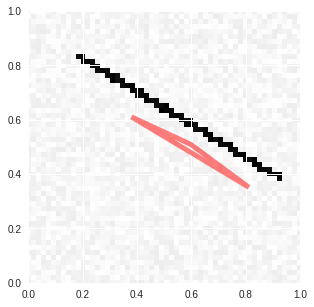

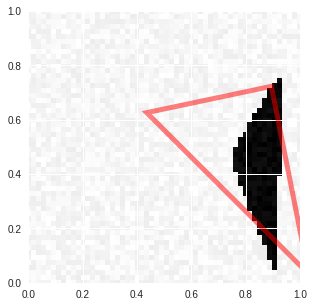

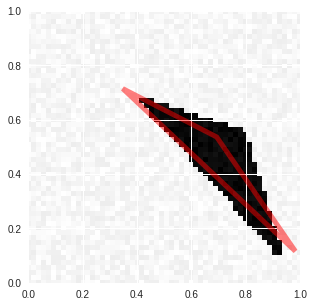

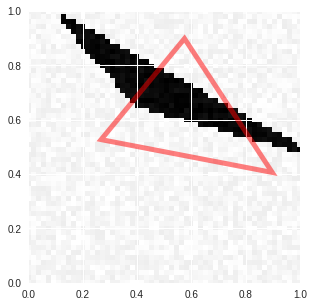

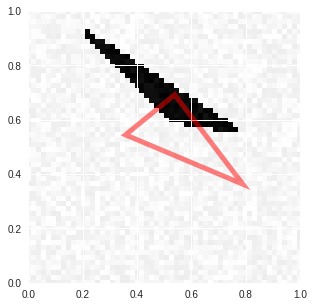

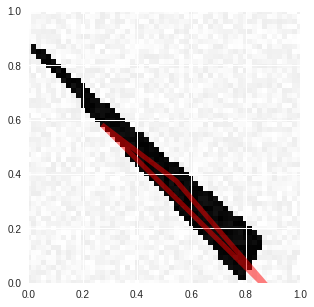

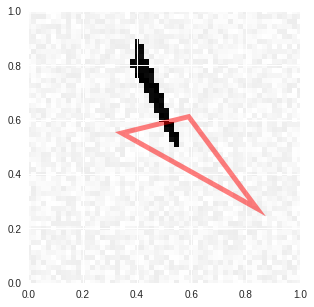

In [98]:
preds_reg_1 = reg_1.predict(X_test_reg)
preds_reg_1 = normalizer.inverse_transform(preds_reg_1)
n = 10
for i in range(n):
    visualize_prediction(X_test_reg[i], preds_reg_1[i])
 

## **Second model**

We improve our model by adding some convolutional layers.

### **Create model**

In [99]:
reg_2 =Sequential()

reg_2.add(Conv2D(40,kernel_size=(5,5),input_shape=(72,72,1,),activation='relu'))
reg_2.add(Dropout(0.3))
reg_2.add(Conv2D(20,kernel_size=(4,4),activation='relu'))
reg_2.add(Flatten())
reg_2.add(Dropout(0.3))
reg_2.add(Dense(6))


#Compile the model 
reg_2.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['mean_squared_error'])

results_reg_2= reg_2.fit(X_train_reg_reshaped,Y_train_reg_norm,epochs=50,batch_size=100, validation_data=(X_test_reg_reshaped, Y_test_reg_norm))

Train on 1000 samples, validate on 300 samples
Epoch 1/50
1000/1000 [==============================] - 30s 30ms/step - loss: 4.4957 - mean_squared_error: 4.4957 - val_loss: 1.0236 - val_mean_squared_error: 1.0236
Epoch 2/50
1000/1000 [==============================] - 29s 29ms/step - loss: 1.0004 - mean_squared_error: 1.0004 - val_loss: 1.0242 - val_mean_squared_error: 1.0242
Epoch 3/50
1000/1000 [==============================] - 29s 29ms/step - loss: 1.0000 - mean_squared_error: 1.0000 - val_loss: 1.0242 - val_mean_squared_error: 1.0242
Epoch 4/50
1000/1000 [==============================] - 29s 29ms/step - loss: 0.9999 - mean_squared_error: 0.9999 - val_loss: 1.0242 - val_mean_squared_error: 1.0242
Epoch 5/50
1000/1000 [==============================] - 29s 29ms/step - loss: 0.9993 - mean_squared_error: 0.9993 - val_loss: 1.0216 - val_mean_squared_error: 1.0216
Epoch 6/50
1000/1000 [==============================] - 29s 29ms/step - loss: 0.9968 - mean_squared_error: 0.9968 - val_los

### **Evaluate model**

In [101]:
eval_reg2 = reg_2.evaluate(X_test_reg_reshaped, Y_test_reg_norm)
print("MSE: ", str(eval_reg2[0]))

300/300 [==============================] - 2s 7ms/step
MSE:  0.533836658000946


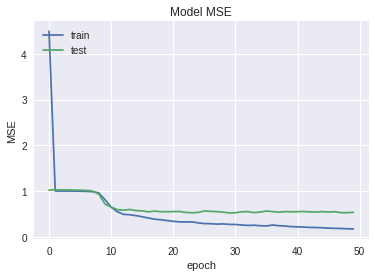

In [102]:
# history for MSE
plt.plot(results_reg_2.history['mean_squared_error'])
plt.plot(results_reg_2.history['val_mean_squared_error'])
plt.title('Model MSE')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### **Visualization**

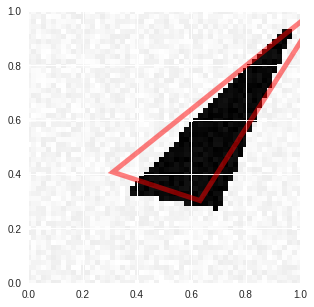

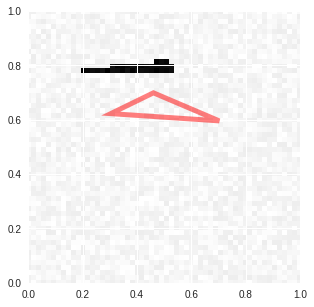

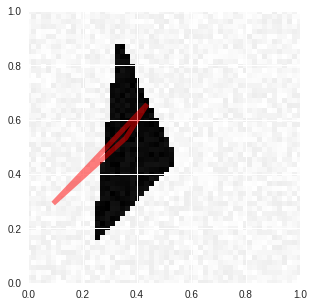

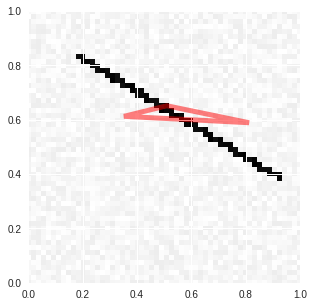

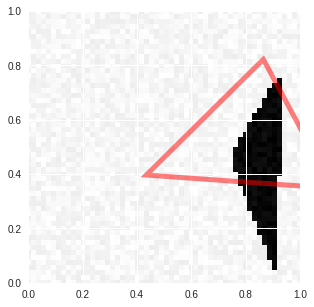

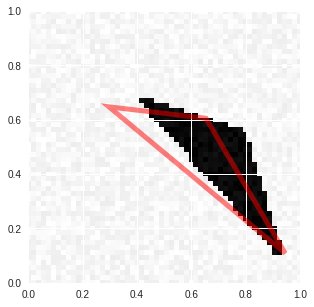

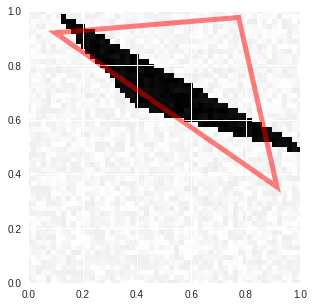

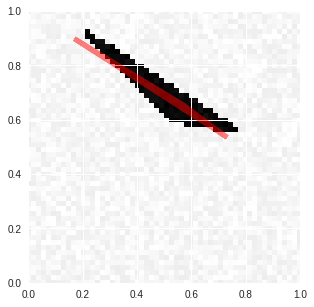

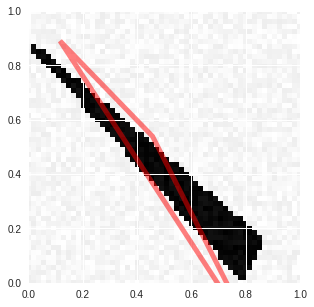

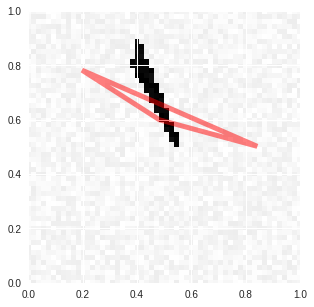

In [103]:
preds_reg_2 = reg_2.predict(X_test_reg_reshaped)
preds_reg_2 = normalizer.inverse_transform(preds_reg_2)

n = 10
for i in range(n):
    visualize_prediction(X_test_reg_reshaped[i], preds_reg_2[i])
 

## **Third model**

As it has been seen in the previous part, we get some awful outcomes taking the data as they were and
trying to train a network on it. What makes the task difficult for the network is that we are asking him
to predict the three vertices of a triangle, but those vertices are given in a random order and the network
can’t figure out this arbitrary order ! Hence a basic idea to improve the outcome is to sort the vertices by
increasing first coordinates (x). 

### **Sort vertices**

In [0]:
Y_train_reg_sorted = Y_train_reg.reshape(Y_train_reg.shape[0], 3,2)
Y_train_reg_sorted   = np.array([i[i[:,0].argsort()] for i in Y_train_reg_sorted]) 
Y_train_reg_sorted = Y_train_reg_sorted.reshape(Y_train_reg_sorted.shape[0], 6,)

Y_test_reg_sorted = Y_test_reg.reshape(Y_test_reg.shape[0], 3,2)
Y_test_reg_sorted   = np.array([i[i[:,0].argsort()] for i in Y_test_reg_sorted]) 
Y_test_reg_sorted = Y_test_reg_sorted.reshape(Y_test_reg_sorted.shape[0], 6,)

In [0]:
normalizer       = StandardScaler()
Y_train_reg_norm = normalizer.fit_transform(Y_train_reg_sorted)
Y_test_reg_norm  = normalizer.transform(Y_test_reg_sorted)

### **Create model**

In [0]:
input_data = Input(shape = (72,72,1,))

## Construction of commun layers

layer_1 = Conv2D(40,kernel_size=(5,5),activation='relu')(input_data)
#layer_2 = Flatten()(layer_1)
layer_2 = Dropout(0.3)(layer_1)
layer_3 = Conv2D(40,kernel_size=(4,4),activation='relu')(layer_2)
layer_4 = Flatten()(layer_3)
layer_5 = Dropout(0.3)(layer_4)

## Construction of separate layers for every vertice

vertice_1 = Dense(20,activation='relu')(layer_5)
vertice_1 = Dense(1)(vertice_1)

vertice_2 = Dense(20,activation='relu')(layer_5)
vertice_2 = Dense(1)(vertice_2)

vertice_3 = Dense(20,activation='relu')(layer_5)
vertice_3 = Dense(1)(vertice_3)

vertice_4 = Dense(20,activation='relu')(layer_5)
vertice_4 = Dense(1)(vertice_4)

vertice_5 = Dense(20,activation='relu')(layer_5)
vertice_5 = Dense(1)(vertice_5)

vertice_6 = Dense(20,activation='relu')(layer_5)
vertice_6 = Dense(1)(vertice_6)

output    = concatenate([vertice_1,
                         vertice_2,
                         vertice_3,
                         vertice_4,
                         vertice_5,
                         vertice_6],axis=1)

reg_3      = Model(input_data,output)

reg_3.compile(loss='mean_squared_error',optimizer='adam', metrics=['mean_squared_error'])

In [119]:
results_reg_3= reg_3.fit(X_train_reg_reshaped,Y_train_reg_norm,epochs=50,batch_size=100, validation_data=(X_test_reg_reshaped, Y_test_reg_norm))

Train on 1000 samples, validate on 300 samples
Epoch 1/50
1000/1000 [==============================] - 49s 49ms/step - loss: 35.4862 - mean_squared_error: 35.4862 - val_loss: 1.0243 - val_mean_squared_error: 1.0243
Epoch 2/50
1000/1000 [==============================] - 44s 44ms/step - loss: 1.0046 - mean_squared_error: 1.0046 - val_loss: 1.0242 - val_mean_squared_error: 1.0242
Epoch 3/50
1000/1000 [==============================] - 44s 44ms/step - loss: 1.0001 - mean_squared_error: 1.0001 - val_loss: 1.0242 - val_mean_squared_error: 1.0242
Epoch 4/50
1000/1000 [==============================] - 44s 44ms/step - loss: 1.0000 - mean_squared_error: 1.0000 - val_loss: 1.0242 - val_mean_squared_error: 1.0242
Epoch 5/50
1000/1000 [==============================] - 44s 44ms/step - loss: 0.9993 - mean_squared_error: 0.9993 - val_loss: 1.0201 - val_mean_squared_error: 1.0201
Epoch 6/50
1000/1000 [==============================] - 44s 44ms/step - loss: 0.9515 - mean_squared_error: 0.9515 - val_l

### **Evaluate model**

In [120]:
eval_reg3 = reg_3.evaluate(X_test_reg_reshaped, Y_test_reg_norm)
print("MSE: ", str(eval_reg3[0]))

300/300 [==============================] - 3s 10ms/step
MSE:  0.35348506609598795


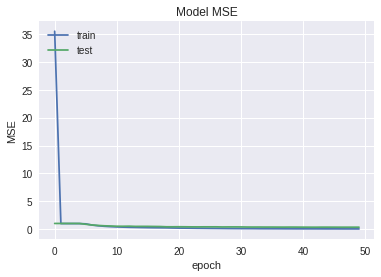

In [121]:
# history for MSE
plt.plot(results_reg_3.history['mean_squared_error'])
plt.plot(results_reg_3.history['val_mean_squared_error'])
plt.title('Model MSE')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### **Visualization**

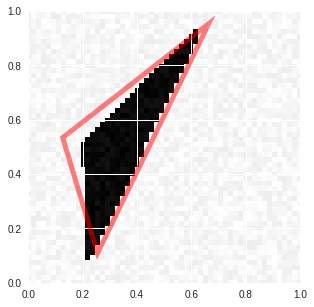

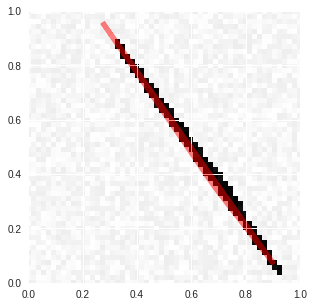

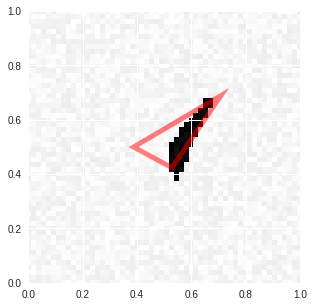

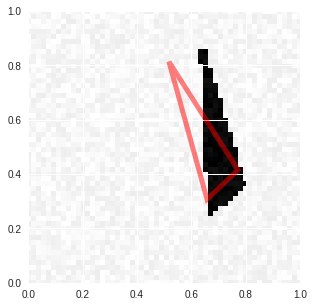

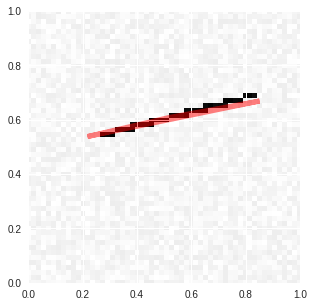

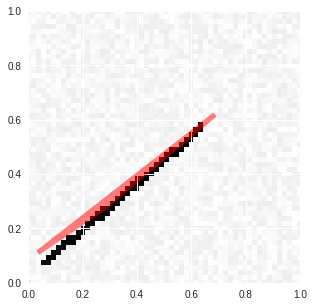

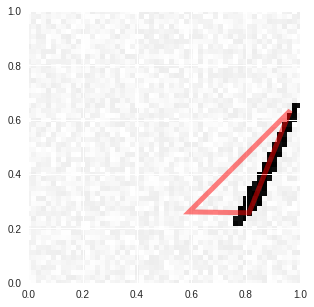

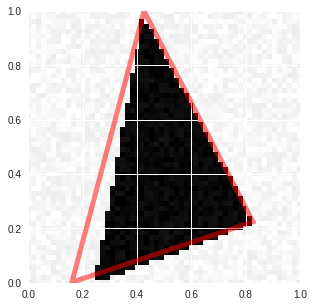

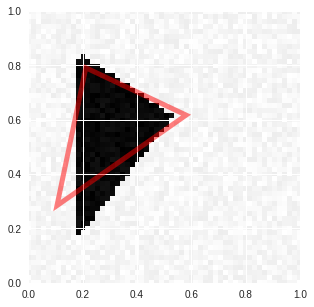

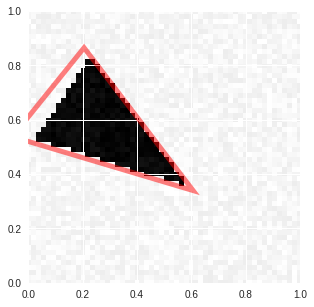

In [127]:
preds_reg_3 = reg_3.predict(X_train_reg_reshaped)
preds_reg_3 = normalizer.inverse_transform(preds_reg_3)

n = 10
for i in range(n):
    visualize_prediction(X_train_reg_reshaped[i], preds_reg_3[i])

# **Image Denoising**

We start this part by modifying the functions that create train and test sets. Indeed, we should have as a train set a set of noised images and as targets the denoised images.

## **Modify functions**

In [0]:
def generate_a_rectangle_denoising(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise), generate_a_drawing(figsize, U, V, 0.)


def generate_a_disk_denoising(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise), generate_a_drawing(figsize, U, V, 0.)

def generate_a_triangle_denoising(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    return generate_a_drawing(figsize, U, V, noise), generate_a_drawing(figsize, U, V, 0.)

def generate_dataset_denoising(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples,im_size])
    for i in range(nb_samples):
        category = np.random.randint(3)
        if category == 0:
            X[i], Y[i] = generate_a_rectangle_denoising(noise, free_location)
        elif category == 1: 
            X[i], Y[i] = generate_a_disk_denoising(noise, free_location)
        else:
            X[i], Y[i] = generate_a_triangle_denoising(noise, free_location)
    X = (X + noise) / (255 + 2 * noise)
    Y = (Y + noise) / (255 + 2 * noise)
    return [X, Y]

def generate_test_set_denoising(nb_samples, noise):
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_denoising(nb_samples, noise, True)
    return [X_test, Y_test]

## **Data preprocessing**

In [0]:
[X_train_nois,Y_train_nois] =generate_dataset_denoising(1000,20)
[X_test_nois,Y_test_nois]   =generate_test_set_denoising(300,20)

X_train_nois_reshaped=X_train_nois.reshape(X_train_nois.shape[0] ,72,72,1 )
Y_train_nois_reshaped=Y_train_nois.reshape(Y_train_nois.shape[0] ,72,72,1 )

X_test_nois_reshaped = X_test_nois.reshape(X_test_nois.shape[0] ,72,72,1 )
Y_test_nois_reshaped = Y_test_nois.reshape(Y_test_nois.shape[0] ,72,72,1 )

We modify the targets in order to get only pixels of two values: 0 or 1. We will use these data in the second part where we will consider our problem as a segmentation problem. 

In [0]:
Y_train_nois_reshaped_seg = (Y_train_nois_reshaped>0.5)*1

Y_test_nois_reshaped_seg = (Y_test_nois_reshaped>0.5)*1

## **Regression**

As a first approach,  we will create a regressor. But for the two approchs, we will use an architecture of encoder_decoder(autodecoder) that try to re-construct the input without noise.

### **Create model**

In [0]:
def autoencoder(input_img):
    #encoder
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) 
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) 
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1) 
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) 
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2) 

    #decoder
    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3) 
    up1 = UpSampling2D((2,2))(conv4) 
    conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(up1) 
    up2 = UpSampling2D((2,2))(conv5) 
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2) 
    return decoded

In [0]:
input_img = Input(shape=(72, 72, 1))  
autoencoder = Model(input_img, autoencoder(input_img))
autoencoder.compile(loss='mean_squared_error', optimizer = RMSprop(), metrics = ['mean_squared_error'])
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        (None, 72, 72, 1)         0         
_________________________________________________________________
conv2d_111 (Conv2D)          (None, 72, 72, 32)        320       
_________________________________________________________________
max_pooling2d_50 (MaxPooling (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_112 (Conv2D)          (None, 36, 36, 64)        18496     
_________________________________________________________________
max_pooling2d_51 (MaxPooling (None, 18, 18, 64)        0         
_________________________________________________________________
conv2d_113 (Conv2D)          (None, 18, 18, 128)       73856     
_________________________________________________________________
conv2d_114 (Conv2D)          (None, 18, 18, 128)       147584    
__________

In [0]:
results_noise = autoencoder.fit(X_train_nois_reshaped, Y_train_nois_reshaped, batch_size=32,epochs=50,verbose=1,validation_split=0.3)


Train on 700 samples, validate on 300 samples
Epoch 1/50
700/700 [==============================] - 46s 66ms/step - loss: 0.1242 - mean_squared_error: 0.1242 - val_loss: 0.0680 - val_mean_squared_error: 0.0680
Epoch 2/50
700/700 [==============================] - 42s 60ms/step - loss: 0.0331 - mean_squared_error: 0.0331 - val_loss: 0.0194 - val_mean_squared_error: 0.0194
Epoch 3/50
700/700 [==============================] - 41s 59ms/step - loss: 0.0135 - mean_squared_error: 0.0135 - val_loss: 0.0122 - val_mean_squared_error: 0.0122
Epoch 4/50
700/700 [==============================] - 41s 59ms/step - loss: 0.0114 - mean_squared_error: 0.0114 - val_loss: 0.0098 - val_mean_squared_error: 0.0098
Epoch 5/50
700/700 [==============================] - 41s 59ms/step - loss: 0.0118 - mean_squared_error: 0.0118 - val_loss: 0.0114 - val_mean_squared_error: 0.0114
Epoch 6/50
700/700 [==============================] - 40s 58ms/step - loss: 0.0108 - mean_squared_error: 0.0108 - val_loss: 0.0077 - v

### **Evaluate model**

In [0]:
eval_noise = autoencoder.evaluate(X_test_nois_reshaped, Y_test_nois_reshaped)
print("Loss: ", str(eval_noise[0]))
print("MSE: ", str(eval_noise[1]))

### **Visualization**

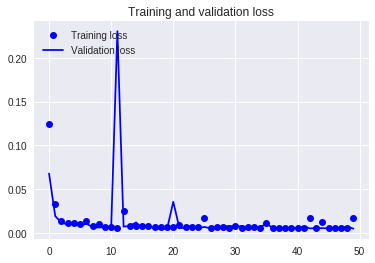

In [0]:
epochs = 50
loss = results_noise.history['loss']
val_loss = results_noise.history['val_loss']
epochs_i = range(epochs)
plt.figure()
plt.plot(epochs_i, loss, 'bo', label='Training loss')
plt.plot(epochs_i, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc='upper left')
plt.show()

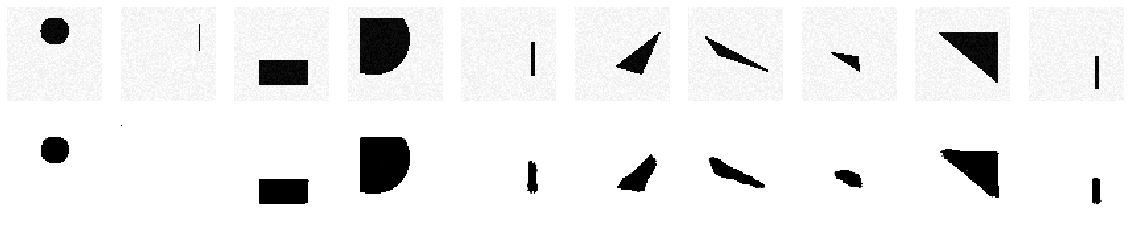

In [0]:
decoded_imgs = autoencoder.predict(X_test_nois_reshaped)
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display noised
    ax = plt.subplot(2, n, i+1)
    plt.imshow(X_test_nois_reshaped[i].reshape(72, 72))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display denoised
    ax = plt.subplot(2, n, i+1 + n)
    plt.imshow(decoded_imgs[i].reshape(72, 72))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

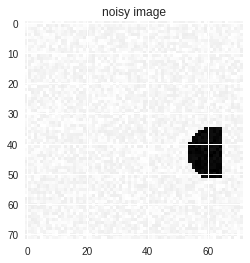

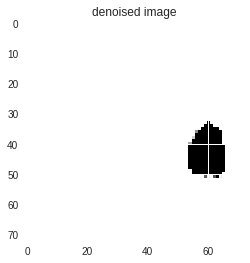

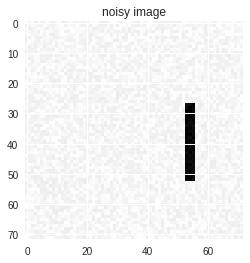

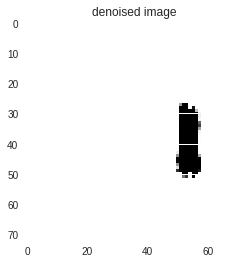

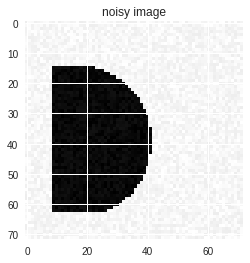

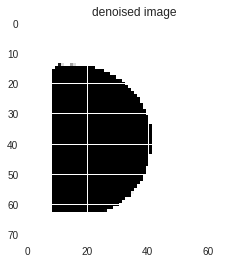

In [0]:
for i in range(3):
    k = np.random.randint(X_test_nois_reshaped.shape[0])
    plt.imshow(X_test_nois_reshaped[k, :, :, 0],  cmap='gray')
    plt.title("noisy image")
    plt.show()
    plt.imshow(decoded_imgs[k,:,:,0], cmap='gray')
    plt.title("denoised image")
    plt.show()

## **Segmentation**

In fact, what we really care is whether the pixel is black or white. Hence we can view the denoising task as a segmentation task where we want to put the background in white and the figure in black. To do so, we modify our
network to add a sigmoid layer. 

### **Create model**

In [0]:
def autoencoder_seg(input_img):
    #encoder
    
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) 
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1) 
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) 
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2) 

    #decoder
    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3) 
    up1 = UpSampling2D((2,2))(conv4) 
    conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(up1) 
    up2 = UpSampling2D((2,2))(conv5) 
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2)
    return decoded

In [0]:
input_img = Input(shape=(72, 72, 1))  
autoencoder_seg = Model(input_img, autoencoder_seg(input_img))
autoencoder_seg.compile(loss='binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
autoencoder_seg.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        (None, 72, 72, 1)         0         
_________________________________________________________________
conv2d_117 (Conv2D)          (None, 72, 72, 32)        320       
_________________________________________________________________
max_pooling2d_52 (MaxPooling (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_118 (Conv2D)          (None, 36, 36, 64)        18496     
_________________________________________________________________
max_pooling2d_53 (MaxPooling (None, 18, 18, 64)        0         
_________________________________________________________________
conv2d_119 (Conv2D)          (None, 18, 18, 128)       73856     
_________________________________________________________________
conv2d_120 (Conv2D)          (None, 18, 18, 128)       147584    
__________

In [0]:
results_noise_seg = autoencoder_seg.fit(X_train_nois_reshaped, Y_train_nois_reshaped_seg, 
                                 epochs=50, 
                                 batch_size=128, 
                                 validation_data=(X_test_nois_reshaped, Y_test_nois_reshaped_seg))



Train on 1000 samples, validate on 300 samples
Epoch 1/50
1000/1000 [==============================] - 60s 60ms/step - loss: 0.4986 - acc: 0.7274 - val_loss: 0.2913 - val_acc: 0.9157
Epoch 2/50
1000/1000 [==============================] - 55s 55ms/step - loss: 0.2676 - acc: 0.8667 - val_loss: 0.0641 - val_acc: 0.9857
Epoch 3/50
1000/1000 [==============================] - 55s 55ms/step - loss: 0.0712 - acc: 0.9821 - val_loss: 0.0679 - val_acc: 0.9814
Epoch 4/50
1000/1000 [==============================] - 57s 57ms/step - loss: 0.0345 - acc: 0.9879 - val_loss: 0.0391 - val_acc: 0.9906
Epoch 5/50
1000/1000 [==============================] - 57s 57ms/step - loss: 0.0235 - acc: 0.9924 - val_loss: 0.0354 - val_acc: 0.9912
Epoch 6/50
1000/1000 [==============================] - 57s 57ms/step - loss: 0.0194 - acc: 0.9936 - val_loss: 0.0313 - val_acc: 0.9910
Epoch 7/50
1000/1000 [==============================] - 57s 57ms/step - loss: 0.0164 - acc: 0.9944 - val_loss: 0.0262 - val_acc: 0.9918
E

### **Evaluate model**

In [0]:
eval_noise_seg = autoencoder_seg.evaluate(X_test_nois_reshaped, Y_test_nois_reshaped_seg)
print("Loss: ", str(eval_noise_seg[0]))
print("Accuracy: ", str(eval_noise_seg[1]))

300/300 [==============================] - 4s 15ms/step
Loss:  0.01566480747113625
Accuracy:  0.9969463682174683


### **Visualization**

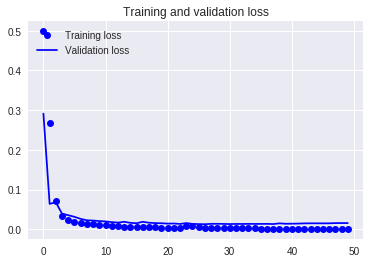

In [0]:
epochs = 50
loss = results_noise_seg.history['loss']
val_loss = results_noise_seg.history['val_loss']
epochs_i = range(epochs)
plt.figure()
plt.plot(epochs_i, loss, 'bo', label='Training loss')
plt.plot(epochs_i, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc='upper left')
plt.show()

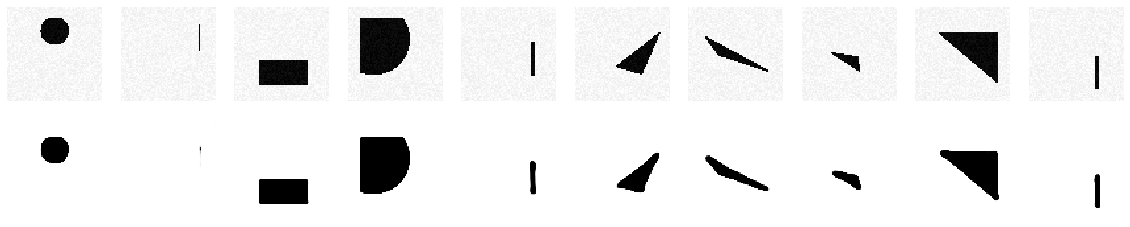

In [0]:
decoded_imgs_seg = autoencoder_seg.predict(X_test_nois_reshaped)
#decoded_imgs_reg = (decoded_imgs_reg>0.5)*1
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display noised
    ax = plt.subplot(2, n, i+1)
    plt.imshow(X_test_nois_reshaped[i].reshape(72, 72))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display denoised
    ax = plt.subplot(2, n, i+1 + n)
    plt.imshow(decoded_imgs_seg[i].reshape(72, 72))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

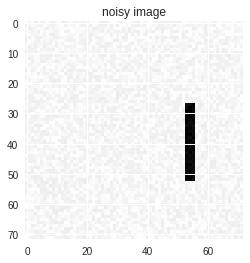

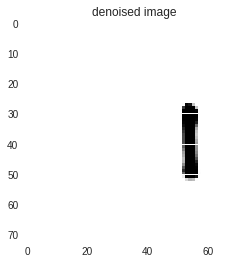

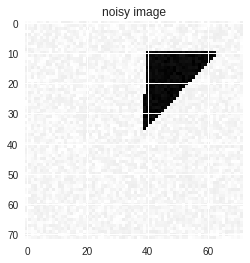

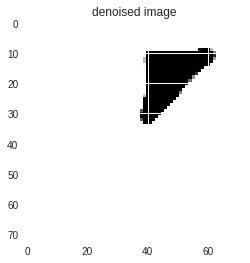

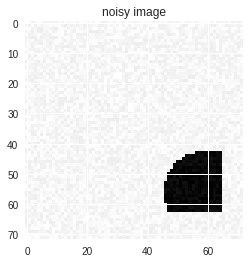

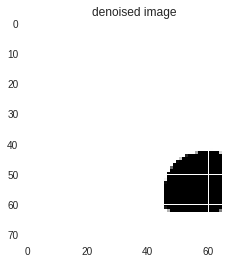

In [0]:
for i in range(3):
    k = np.random.randint(X_test_nois_reshaped.shape[0])
    plt.imshow(X_test_nois_reshaped[k, :, :, 0],  cmap='gray')
    plt.title("noisy image")
    plt.show()
    plt.imshow(decoded_imgs_seg[k,:,:,0], cmap='gray')
    plt.title("denoised image")
    plt.show()